This post is inspired by a [question](https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg07707.html) that came up on the mailing list recently. The poster was looking for help doing bioisotere replacements with the RDKit. The topic is interesting and seems useful enough to merit a short blog post.

In [1]:
# start with the usual imports
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import time
from rdkit import rdBase
print(time.asctime())
print(rdBase.rdkitVersion)

Wed Feb  7 15:10:15 2018
2017.09.3


We'll start with some amide (or ester) isosteres taken from [here](http://www.f.u-tokyo.ac.jp/~kanai/seminar/pdf/Lit_Y_Morita_M1.pdf):

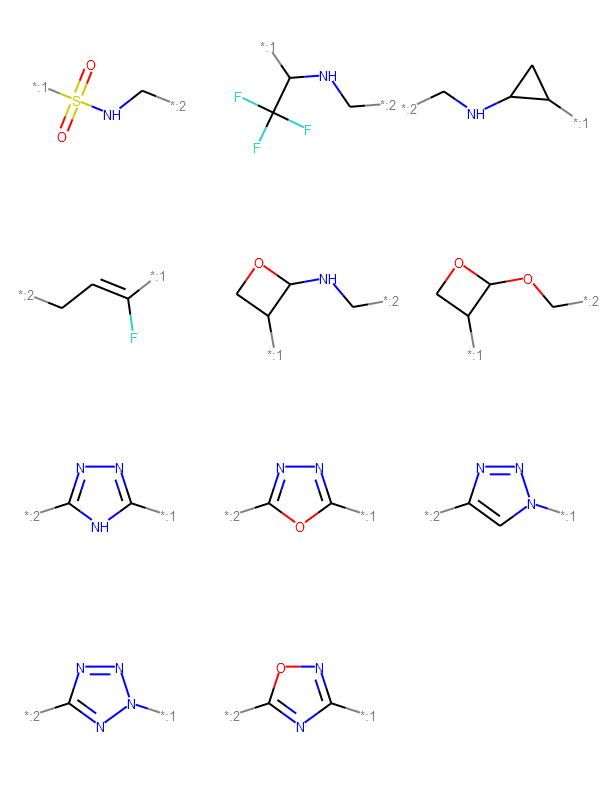

In [2]:
isostere_smis = ('[*:1]S(=O)(=O)NC[*:2]',
                '[*:1]C(C(F)(F)(F))NC[*:2]',
                '[*:1]C1CC1NC[*:2]',
                '[*:1]C(F)=CC[*:2]',
                '[*:1]C1COC1NC[*:2]',
                '[*:1]C1COC1OC[*:2]',
                '[*:1]C1=NN=C([*:2])N1',
                '[*:1]C1=NN=C([*:2])O1',
                '[*:1]N1N=NC([*:2])=C1',
                '[*:1]N1N=NC([*:2])=N1',
                '[*:1]C1=NOC([*:2])=N1')
isosteres = [Chem.MolFromSmiles(x) for x in isostere_smis]
Draw.MolsToGridImage(isosteres)

And now we'll use those to build the reactions that we'll use to apply the bioisosteric transformations.

In [3]:
def buildIsostereReaction(start,replacement):
    qps = Chem.AdjustQueryParameters()
    qps.adjustDegree = False
    qps.adjustHeavyDegree = False
    qps.adjustRingCount = False
    qps.aromatizeIfPossible = False
    qps.makeAtomsGeneric = False
    qps.makeBondsGeneric = False
    qps.makeDummiesQueries = True
    start = Chem.AdjustQueryProperties(start,qps)
    replacement = Chem.AdjustQueryProperties(replacement,qps)
    product = AllChem.ChemicalReaction()
    product.AddReactantTemplate(start)
    product.AddProductTemplate(replacement)
    product.Initialize()
    return product

Create all the reactions and take a look at one of them to get a sense of what we're doing:

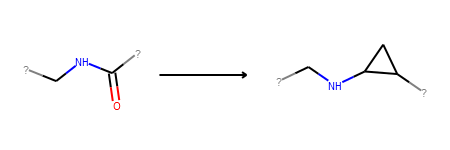

In [4]:
amide = Chem.MolFromSmiles('[*:1]C(=O)NC[*:2]')
isostereReactions =[buildIsostereReaction(amide,x) for x in isosteres]
isostereReactions[2]

Here are the functions for using those reactions:

In [5]:
def doIsostereReplacement(mol,rxn):
    ps = rxn.RunReactants((mol,))
    res = [x[0] for x in ps]
    return res
def doIsostereReplacements(mol,rxns):
    res = []
    for i,rxn in enumerate(rxns):
        seenSoFar=set()
        ims = doIsostereReplacement(mol,rxn)
        p0 = rxn.GetProductTemplate(0)
        # save where the match is
        for im in ims:
            smi = Chem.MolToSmiles(im,True)
            if smi not in seenSoFar:
                im.coreMatches = im.GetSubstructMatch(p0)
                res.append(im)
                seenSoFar.add(smi)
    return res

We'll use capsaicin as our example

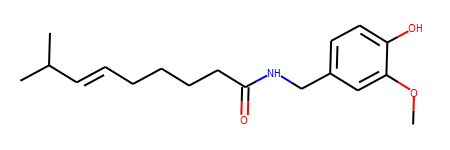

In [6]:
mol =Chem.MolFromSmiles('COc1cc(CNC(=O)CCCC/C=C/C(C)C)ccc1O')
mol

Get all the products of applying our isosteric replacements:

In [7]:
subs = doIsostereReplacements(mol,isostereReactions)
len(subs)

11

Let's look at what we got back and, though it's mostly obvious, highlight the replacement:

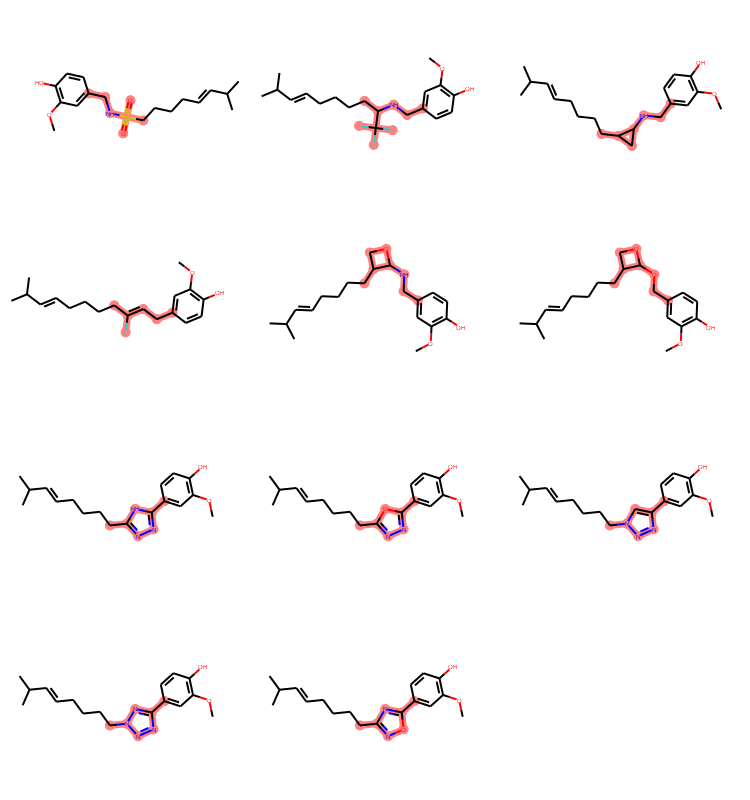

In [8]:
atomsToHighlight = [sub.coreMatches for sub in subs]
Draw.MolsToGridImage(subs,subImgSize=(250,200),highlightAtomLists=atomsToHighlight)

As I promised above, this is a short one, so that's it for now.

Comments, questions, or pointers to other lists of useful bioisosteres are welcome!